### GPUを有効にします

メニューのRuntime -> Change Runtime typeからHardware AcceleratorでGPUを選びます。

### データセットの読み込み

In [3]:
# data-content-half.zipをアップロード
from google.colab import files
uploaded = files.upload()

Saving data-content-half.zip to data-content-half.zip


In [4]:
# ファイルの解凍
!unzip intarface-201812-3-data-content.zip

Archive:  data-content-half.zip
   creating: data-content/
   creating: data-content/test/
   creating: data-content/test/burger/
  inflating: data-content/test/burger/IMG_20180718_185022_half.jpg  
  inflating: data-content/test/burger/IMG_20180718_185110_half.jpg  
  inflating: data-content/test/burger/IMG_20180718_185231_half.jpg  
  inflating: data-content/test/burger/P1040719_half.JPG  
  inflating: data-content/test/burger/P1040732_half.JPG  
  inflating: data-content/test/burger/P1040733_half.JPG  
  inflating: data-content/test/burger/P1040740_half.JPG  
  inflating: data-content/test/burger/P1040745_half.JPG  
  inflating: data-content/test/burger/P1040751_half.JPG  
  inflating: data-content/test/burger/P1040758_half.JPG  
   creating: data-content/test/cheese/
  inflating: data-content/test/cheese/IMG_20180718_190513_half.jpg  
  inflating: data-content/test/cheese/IMG_20180718_190619_half.jpg  
  inflating: data-content/test/cheese/P1040485_half.JPG  
  inflating: data-cont

In [9]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 入力サイズはここで変えます。
im_rows, im_cols = (296, 296)
bs = 32
TRAIN_DIR = "data-content/train"
TEST_DIR = "data-content/test"

# featurewiseの計算の準備のため学習データのIterator
train_batchs = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TRAIN_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = "categorical"
)

x_train = np.array([])
x_train.resize((0, im_rows, im_cols, 3))
for i in range(int(train_batchs.samples/bs) + 1):
    imgs, labels = next(train_batchs)
    x_train = np.vstack((x_train, imgs))

# 学習データのGenerator
datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    horizontal_flip = True,
    vertical_flip = True,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zca_whitening = False,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 45,
)
datagen.fit(x_train)

# 学習データのIterator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = "categorical",
)

# featurewiseの計算の準備のためテストデータのIterator
test_batchs = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = "categorical"
)

x_test = np.array([])
x_test.resize((0, im_rows, im_cols, 3))
for i in range(int(test_batchs.samples/bs) + 1):
    imgs, labels = next(test_batchs)
    x_test = np.vstack((x_test, imgs))

# テストデータのGenerator
test_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zca_whitening = False
)

test_datagen.fit(x_test)

# テストデータのIterator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = "categorical",
)

Found 480 images belonging to 19 classes.
Found 480 images belonging to 19 classes.
Found 190 images belonging to 19 classes.
Found 190 images belonging to 19 classes.


### モデル構築

In [10]:
from keras.applications.vgg16 import VGG16

# モデルの構築とImageNetで学習済みの重みの読み込み
base_model = VGG16(include_top=False, weights='imagenet', pooling=None)

In [11]:
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model

nb_classes=19

# FC層を構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)
model =  Model(inputs=base_model.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### トレーニング

#### 全結合層のプレ・トレーニング

In [12]:
# 最後のDense以外を固定する
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.summary()

epochs = 4
s_epochs = int(train_generator.samples / bs)

# train the model on the new data for a few epochs
# まずはDenseレイヤを学習する
model.fit_generator(train_generator, steps_per_epoch=s_epochs, epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### ファインチューニング

In [13]:
# 全層のうちで8割は固定し、それ以降は学習対象とする
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.8)]:
   layer.trainable = False
for layer in model.layers[int(layer_num * 0.8):]:
   layer.trainable = True

lr, decay, eps, bs = (0.001, 1e-3, 1e-8, 32)

from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=lr, decay=decay, epsilon=eps), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [14]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

epochs = 500
s_epochs = int(train_generator.samples / bs)
v_steps = int(test_generator.samples / bs)

fpath = 'umaibar_'+ base_model.name + '_weights.{epoch:03d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.h5'
cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tb_cb = TensorBoard(log_dir="./tensorlog", histogram_freq=0)
es_cb = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=60, min_delta=0.0001)

model.fit_generator(
    train_generator, 
    steps_per_epoch=s_epochs, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=v_steps,
    callbacks=[cp_cb, tb_cb, es_cb]
)


Epoch 1/500
15/15 [==============================] - 17s 1s/step - loss: 2.6205 - acc: 0.2062 - val_loss: 2.3917 - val_acc: 0.2375

Epoch 00001: val_loss improved from inf to 2.39165, saving model to umaibar_vgg16_weights.001-2.62-0.21-2.39-0.24.h5
Epoch 2/500
15/15 [==============================] - 13s 894ms/step - loss: 1.9420 - acc: 0.4062 - val_loss: 1.7198 - val_acc: 0.4437

Epoch 00002: val_loss improved from 2.39165 to 1.71982, saving model to umaibar_vgg16_weights.002-1.94-0.41-1.72-0.44.h5
Epoch 3/500
15/15 [==============================] - 14s 930ms/step - loss: 1.4299 - acc: 0.5042 - val_loss: 1.4694 - val_acc: 0.4875

Epoch 00003: val_loss improved from 1.71982 to 1.46942, saving model to umaibar_vgg16_weights.003-1.43-0.50-1.47-0.49.h5
Epoch 4/500
15/15 [==============================] - 14s 916ms/step - loss: 1.1900 - acc: 0.5875 - val_loss: 1.1575 - val_acc: 0.6062

Epoch 00004: val_loss improved from 1.46942 to 1.15746, saving model to umaibar_vgg16_weights.004-1.19-0

15/15 [==============================] - 14s 929ms/step - loss: 0.0495 - acc: 0.9896 - val_loss: 0.5103 - val_acc: 0.8375

Epoch 00083: val_loss did not improve from 0.35335
Epoch 84/500
15/15 [==============================] - 14s 914ms/step - loss: 0.0461 - acc: 0.9938 - val_loss: 0.3965 - val_acc: 0.8688

Epoch 00084: val_loss did not improve from 0.35335
Epoch 85/500
15/15 [==============================] - 14s 903ms/step - loss: 0.0391 - acc: 0.9854 - val_loss: 0.4923 - val_acc: 0.8375

Epoch 00085: val_loss did not improve from 0.35335
Epoch 86/500
15/15 [==============================] - 14s 918ms/step - loss: 0.0490 - acc: 0.9812 - val_loss: 0.4232 - val_acc: 0.8375

Epoch 00086: val_loss did not improve from 0.35335
Epoch 87/500
15/15 [==============================] - 14s 934ms/step - loss: 0.0581 - acc: 0.9833 - val_loss: 0.5154 - val_acc: 0.8313

Epoch 00087: val_loss did not improve from 0.35335
Epoch 88/500
15/15 [==============================] - 14s 945ms/step - loss: 0

### 学習済み最良モデルの重みファイル読み込み

In [27]:
# 上で出来上がったval_lossが一番小さいモデルの重みファイルの読み込み
BEST_SCORE_WEIGHTS_FILE = 'umaibar_vgg16_weights.059-0.08-0.98-0.35-0.88.h5'
model.load_weights(BEST_SCORE_WEIGHTS_FILE, by_name=False)

from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### モデル評価

In [28]:
score = model.evaluate_generator(test_generator, steps=6) # 1バッチごとに32枚取り出し、6回(step)繰り返すと190枚すべて取り出せる
scores = model.predict_generator(test_generator, steps=6)

print("Loss: ", score[0], "Accuracy: ", score[1])

In [51]:
# 日本語を図に入れたい場合はフォントをインストールする必要があります
target_classes = ['テリヤキバーガー', 'チーズ', 'チキンカレー', 'チョコレート', 'コンポタージュ', 'エビマヨネーズ', 
           'レモンスカッシュ', 'めんたい', 'なっとう', 'プレミアムチーズ', 'プレミアム明太子', 'プレミアムステーキ', 
           'シュガーラスク', 'やさいサラダ', 'サラミ', 'たこ焼き', '牛タン塩', 'とんかつソース', 'やきとり']
#target_classes = ['burger', 'cheese', 'chicken_curry', 'chocolate', 'corn', 'ebimayo', 'lemon', 'mentai', 'natto',
#                 'premium_cheese', 'premium_mentai', 'premium_steak', 'rusk', 'salad', 'salami', 'takoyaki', 'tongue', 'tonkatsu',
#                 'yakitori']

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_preds = np.argmax(scores, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_preds)
print(cm)
print('Classification Report')

print(classification_report(test_generator.classes, y_preds, target_names=target_classes))

Confusion Matrix
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  7  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  1  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  8  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  2  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  8  0  0  1]
 [ 0  0  0  0  1  0  0 

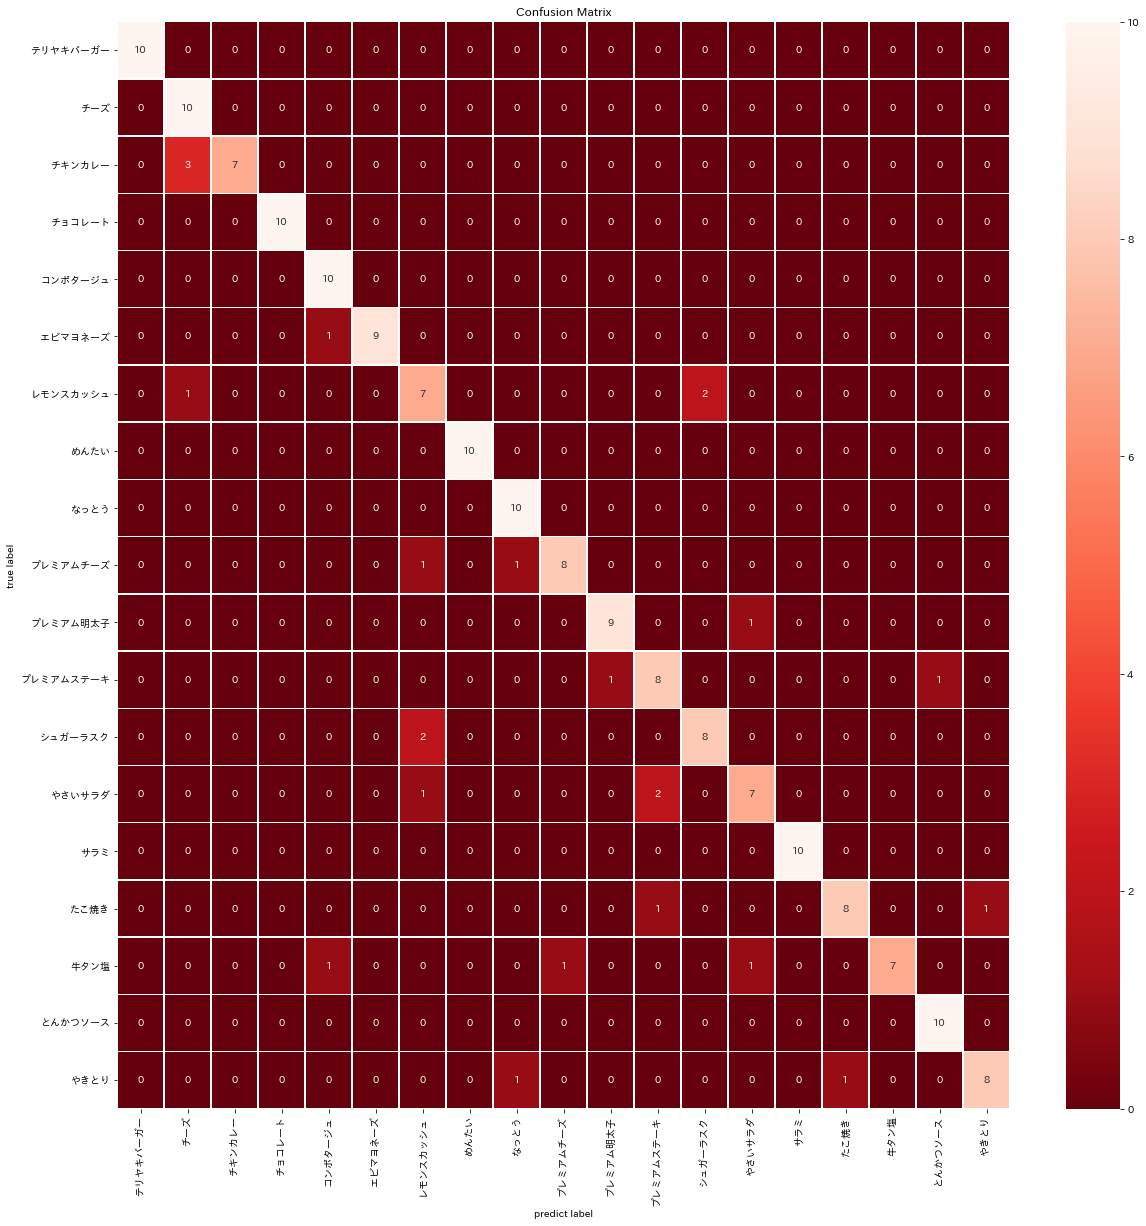

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20,20))
ax= plt.subplot()
df = pd.DataFrame(data=cm, columns=target_classes, index=target_classes)
sns.heatmap(df, annot=True, ax = ax, linewidths=.5, fmt="d", cmap='Reds_r'); #annot=True to annotate cells

# labels, title and ticks
#ax.set_xlabel('予測結果')
#ax.set_ylabel('正解ラベル')
ax.set_xlabel('predict label')
ax.set_ylabel('true label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_classes, rotation='vertical')
ax.yaxis.set_ticklabels(target_classes, rotation='horizontal')
plt.show()

In [0]:
import csv

with open('umaibo_predict' + base_model.name + '.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(['filename'] + target_classes)

    for i, file in enumerate(test_generator.filenames):
        if i < len(scores):
            writer.writerow([file]+[str(x) for x in scores[i]])


In [32]:
import pandas as pd

df = pd.read_csv('umaibo_predict' + base_model.name + '.csv', names=target_classes)
df

,burger,cheese,chicken_curry,chocolate,corn,ebimayo,lemon,mentai,natto,premium_cheese,premium_mentai,premium_steak,rusk,salad,salami,takoyaki,tongue,tonkatsu,yakitori
filename,テリヤキバーガー,チーズ,チキンカレー,チョコレート,コンポタージュ,エビマヨネーズ,レモンスカッシュ,めんたい,なっとう,プレミアムチーズ,プレミアム明太子,プレミアムステーキ,シュガーラスク,やさいサラダ,サラミ,たこ焼き,牛タン塩,とんかつソース,やきとり
burger/IMG_20180718_185022_half.jpg,0.99830437,1.0168022e-16,6.9188466e-10,2.1062195e-11,4.228997e-20,5.1409663e-09,7.2895764e-14,4.687776e-12,1.2435257e-07,3.2481295e-09,4.9132946e-14,0.0003799157,2.0310042e-16,1.5933863e-10,4.135011e-10,2.059198e-09,5.7920007e-15,0.0013156076,4.888193e-08
burger/IMG_20180718_185110_half.jpg,0.8285078,7.4443343e-17,8.022599e-11,2.1508599e-11,6.744382e-17,5.3230107e-08,9.637113e-15,4.3826186e-11,3.4575565e-05,1.2741225e-09,1.08388445e-08,0.16967359,7.828273e-18,1.6318094e-07,1.0257554e-07,5.5093565e-06,4.0174288e-12,0.0017767231,1.4082304e-06
burger/IMG_20180718_185231_half.jpg,0.99973077,2.533279e-13,1.6232669e-09,1.4293844e-08,8.988203e-15,5.8128844e-06,9.863683e-12,1.8728196e-11,0.00017761161,4.975434e-08,6.1418128e-12,4.3153574e-05,5.3893673e-13,6.115524e-08,1.920042e-06,1.0982426e-08,2.3309772e-09,4.0228235e-05,2.548011e-07
burger/P1040719_half.JPG,0.99999964,2.522164e-22,9.477693e-19,1.2692587e-12,1.1731412e-26,4.26538e-10,4.839052e-19,2.7956167e-23,1.3468814e-08,1.7883199e-13,6.50488e-26,2.627015e-12,7.36121e-20,2.8781292e-14,1.1171485e-13,6.284511e-16,1.30749e-20,3.2786951e-07,1.0283357e-16
burger/P1040733_half.JPG,1.0,2.7965682e-22,2.7745132e-19,3.233563e-10,1.0336995e-26,5.5246372e-14,9.598451e-20,3.7489803e-22,2.399022e-11,1.4938486e-15,5.078357e-24,2.533135e-13,1.4954937e-26,9.250465e-12,1.4000057e-13,4.9845267e-15,4.5402894e-19,8.861762e-11,3.619562e-17
burger/P1040740_half.JPG,0.9999988,4.31964e-22,1.9746165e-20,7.330671e-17,2.7152517e-23,1.1760605e-09,8.957346e-21,2.1366273e-26,1.1194616e-06,3.976539e-15,5.903233e-22,3.236624e-11,2.879452e-24,2.953985e-08,4.9591234e-12,1.4317197e-18,1.8334799e-14,4.7829254e-12,6.1198666e-17
burger/P1040744_half.JPG,0.9999999,5.6298704e-26,7.689414e-22,1.7268225e-16,4.1299398e-29,9.753624e-12,1.6054559e-22,4.6811456e-26,7.006912e-08,6.671859e-17,1.0923373e-26,1.8343478e-12,3.9713517e-26,1.2947554e-11,1.7699079e-13,3.4354755e-19,1.1745311e-16,1.1385424e-08,2.8589433e-17
burger/P1040745_half.JPG,0.9999404,2.0708872e-19,1.8573692e-15,1.1486749e-10,2.3245388e-24,4.5796252e-08,6.122592e-17,9.320753e-16,3.4851037e-05,1.9393189e-13,2.203523e-19,2.9207403e-09,3.4429706e-20,1.0420033e-07,2.5262726e-13,2.566467e-13,5.3105296e-13,2.4724637e-05,5.7340704e-10
burger/P1040751_half.JPG,1.0,2.7825868e-36,1.1263724e-32,1.7753842e-22,2.1573973e-36,9.100267e-18,3.3154493e-30,0.0,2.5132064e-13,1.1350711e-27,3.1790233e-38,7.4511427e-19,7.05394e-38,1.7973866e-16,3.88377e-14,1.424519e-26,4.1251262e-27,1.1879274e-16,3.1321798e-34


### 注目領域の可視化

参考にしたコード

* Grad-CAM, Guided Grad-CAM https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py

#### Grad-CAM

In [33]:
import keras.backend as K
import cv2

def grad_cam(model, image, x, layer_name):
    # predict target image
    predictions = model.predict(x, batch_size=1, verbose=0)
    class_idx = np.argmax(predictions[0])
    loss = model.output[:, class_idx]

    conv_output = model.get_layer(layer_name).output
    
    grads = K.gradients(loss, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])

    # get gradients
    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # mean and dot
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.dot(output, weights)

    # create heatmap
    cam = cv2.resize(cam, (im_rows, im_cols), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # coloring
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)  # to RGB
    cam = (np.float32(cam) + image) # composite original image
    
    return cam, heatmap, class_idx


In [34]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

TEST_IMG = 'data-content/test/burger/IMG_20180718_185022_half.jpg'
image = img_to_array(load_img(TEST_IMG, target_size=(im_rows, im_cols)))
image = np.expand_dims(image, axis=0)
x = test_datagen.flow(image, batch_size=1, shuffle=False)

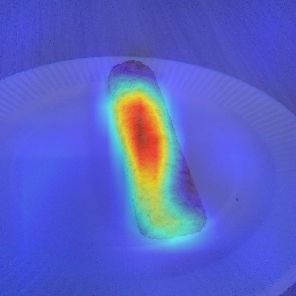

In [35]:
cam, heatmap, predictions = grad_cam(model, image, x.next(), "block5_conv3")
array_to_img(cam[0])

#### Guided Grad-CAM

In [36]:
from tensorflow.python.framework import ops
import keras
import tensorflow as tf

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        base_model = VGG16(include_top=False, weights='imagenet', pooling=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(nb_classes, activation='softmax')(x)
        new_model =  Model(inputs=base_model.input, outputs=predictions)
        
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [37]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')

guided_model.load_weights(BEST_SCORE_WEIGHTS_FILE, by_name=False)

guided_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

saliency_fn = compile_saliency_function(guided_model, activation_layer='block5_conv3')

def saliency_process(x):
    return saliency_fn([x])

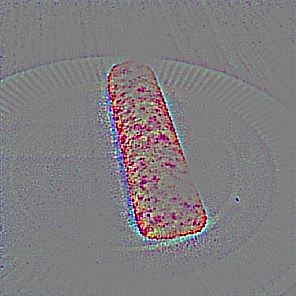

In [38]:
saliency = saliency_process(x.next())
guided = saliency[0] * heatmap[..., np.newaxis]
array_to_img(deprocess_image(guided))

In [39]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import array_to_img, img_to_array

def walk_grad_cam(target_dir, pred_generator, layer_name):
    images = []
    guided_images = []
    for dirpath, dirnames, filenames in os.walk(target_dir):
        for file in sorted(filenames):
            image = img_to_array(load_img(os.path.join(dirpath, file), target_size=(im_rows, im_cols)))
            x = pred_generator.next()[0]  # ImageDataGeneratorの前処理を行いたいため
            cam, heatmap, class_idx = grad_cam(model, image, x, layer_name)
            cam_image = array_to_img(cam)
            cam_image.save(os.path.join(dirpath, os.path.splitext(file)[0] + '_gradcam.jpg'), 'JPEG', quality=100, optimize=True)
            
            saliency = saliency_process(x)
            gradcam = saliency[0] * heatmap[..., np.newaxis]
            guided_cam_image = array_to_img(deprocess_image(gradcam))
            guided_cam_image.save(os.path.join(dirpath, os.path.splitext(file)[0] + '_guided.jpg'), 'JPEG', quality=100, optimize=True)

            images.append([class_idx, cam_image, guided_cam_image])

    # 同じフォルダに保存します。次のテスト前に削除する必要があります。
    (d, filename) = os.path.split(target_dir)
    result_images = 'gradcam_'+ filename + '.jpg'
    # 生成した画像を3x3で描画
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0.3)
    for i in range(9):
        img = images[i][1]
        plt.subplot(gs[i])
        plt.imshow(img, aspect='auto')
        plt.title(target_classes[images[i][0]])
        plt.axis("off")
    plt.savefig(result_images)
    plt.close(fig)

    result_images = 'guided_'+ filename + '.jpg'
    # 生成した画像を3x3で描画
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0.3)
    for i in range(9):
        img = images[i][2]
        plt.subplot(gs[i])
        plt.imshow(img, aspect='auto')
        plt.title(target_classes[images[i][0]])
        plt.axis("off")
    plt.savefig(result_images)
    plt.close(fig)


#### 全テストデータでGrad-CAMおよびGuidedを実行

In [40]:
pred_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(im_rows, im_cols),
    batch_size=1,
    color_mode='rgb',
    shuffle=False,
    class_mode="categorical"
)
test_generator.reset()

# DirectoryIterator, sortedは文字列順でソートする。
for dirpath, dirnames, filenames in os.walk(TEST_DIR):
    for dirname in sorted(dirnames):
        walk_grad_cam(os.path.join(dirpath, dirname), pred_generator, 'block5_conv3')

Found 190 images belonging to 19 classes.


#### CAM画像を保存

In [41]:
!find data-content -name \*_guided.jpg -print | xargs tar jcf guided-data-content.tar.bz2
!find data-content -name \*_gradcam.jpg -print | xargs tar jcf gradcam-data-content.tar.bz2

#### 同じフォルダに作られたCAM画像を削除

In [42]:
!find data-content -name \*_guided.jpg -print | xargs rm -f
!find data-content -name \*_gradcam.jpg -print | xargs rm -f

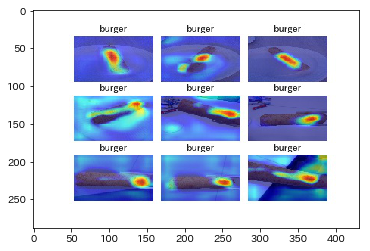

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
im = Image.open('gradcam_burger.jpg', 'r')
plt.imshow(np.array(im))

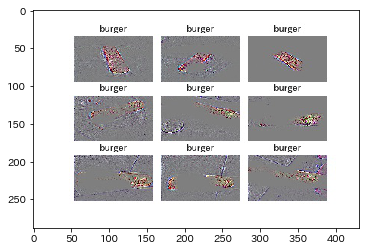

In [44]:
im = Image.open('guided_burger.jpg', 'r')
plt.imshow(np.array(im))